In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from memory.agent import HandcraftedAgent
import room_env

In [2]:
from tqdm.notebook import tqdm
import numpy as np
import gym

env_params = {
    "room_size": "small",
    "weighting_mode": "highest",
    "probs": {
        "commonsense": 0.7,
        "new_location": 0.1,
        "new_object": 0.1,
        "switch_person": 0.5,
    },
    "limits": {
        "heads": None,
        "tails": None,
        "names": None,
        "allow_spaces": False,
    },
    "max_step": 1000,
    "disjoint_entities": True,
    "num_agents": 1,
}


results_all = {}
seeds = [0, 1, 2, 3, 4]
caps = [4, 8, 16, 32]
num_agentss = [1]
agent_types = [
    "episodic",
    "semantic",
    "episodic_semantic",
    "episodic_semantic_pretrain",
]

for agent_type in tqdm(agent_types):
    results_all[agent_type] = {}
    strategy_types = []
    if agent_type == "episodic":
        for forget_policy in ["oldest", "random"]:
            for answer_policy in ["latest", "random"]:
                strategy_types.append(f"{forget_policy}_{answer_policy}")

    elif agent_type == "semantic":
        for forget_policy in ["weakest", "random"]:
            for answer_policy in ["strongest", "random"]:
                strategy_types.append(f"{forget_policy}_{answer_policy}")
    elif agent_type == "episodic_semantic":
        for forget_policy in ["generalize", "random"]:
            for answer_policy in ["episem", "random"]:
                strategy_types.append(f"{forget_policy}_{answer_policy}")
    else:
        for forget_policy in ["oldest", "random"]:
            for answer_policy in ["episem", "random"]:
                strategy_types.append(f"{forget_policy}_{answer_policy}")

    for capacity in caps:
        results_all[agent_type][capacity] = {}
        for strategy_type in strategy_types:
            results_all[agent_type][capacity][strategy_type] = {}
            for num_agents in num_agentss:
                stats = []
                for seed in seeds:

                    forget_policy, answer_policy = strategy_type.split("_")
                    if agent_type == "episodic":
                        episodic_capacity = capacity
                        semantic_capacity = 0
                    elif agent_type == "semantic":
                        episodic_capacity = 0
                        semantic_capacity = capacity
                    else:
                        episodic_capacity = capacity // 2
                        semantic_capacity = capacity // 2

                    env_params["num_agents"] = num_agents
                    env = gym.make("RoomEnv-v0", **env_params)
                    agent = HandcraftedAgent(
                        seed=seed,
                        agent_type=agent_type,
                        forget_policy=forget_policy,
                        answer_policy=answer_policy,
                        episodic_capacity=episodic_capacity,
                        semantic_capacity=semantic_capacity,
                        env=env,
                    )
                    agent.run()
                    stats.append(agent.rewards)
                results_all[agent_type][capacity][strategy_type][num_agents] = {
                    "mean": round(np.mean(stats).item(), 4),
                    "std": round(np.std(stats).item(), 4),
                }

  0%|          | 0/4 [00:00<?, ?it/s]

episodic [239.6, 399.8, 459.0, 489.4]
semantic [137.4, 312.6, 501.4, 541.0]
episodic_semantic [123.8, 298.4, 483.6, 597.0]
episodic_semantic_pretrain [194.6, 412.2, 625.4, 692.2]


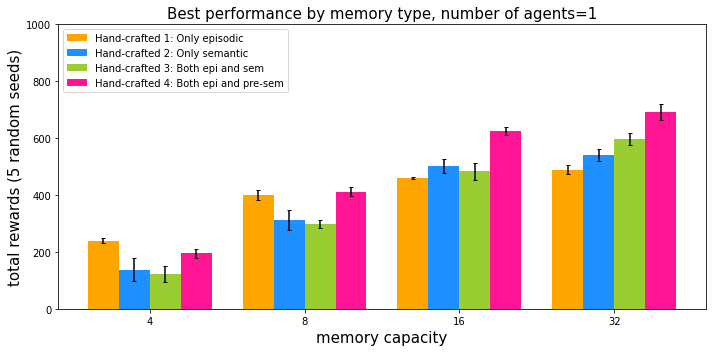

In [3]:
import matplotlib.pyplot as plt

for num_agents in num_agentss:
    fig, ax = plt.subplots(figsize=(10, 5))
    idx = np.asanyarray([i for i in range(len(caps))])
    width = 0.2

    legend_order = [
        "Hand-crafted 1: Only episodic",
        "Hand-crafted 2: Only semantic",
        "Hand-crafted 3: Both epi and sem",
        "Hand-crafted 4: Both epi and pre-sem",
    ]

    color_order = ["orange", "dodgerblue", "yellowgreen", "deeppink"]

    for agent_type, w, color in zip(agent_types, [-1.5, -0.5, 0.5, 1.5], color_order):
        if agent_type == "episodic":
            strategy_type = "oldest_latest"
        elif agent_type == "semantic":
            strategy_type = "weakest_strongest"
        elif agent_type == "episodic_semantic":
            strategy_type = "generalize_episem"
        else:
            strategy_type = "oldest_episem"

        means = [
            results_all[agent_type][capacity][strategy_type][num_agents]["mean"]
            for capacity in caps
        ]
        stds = [
            results_all[agent_type][capacity][strategy_type][num_agents]["std"]
            for capacity in caps
        ]

        print(agent_type, means)
        ax.bar(
            x=idx + w * width,
            height=means,
            yerr=stds,
            width=width,
            color=color,
            capsize=2,
        )
        ax.set_xticks(idx)
        ax.set_xticklabels(caps)
        ax.legend(legend_order, fontsize=10, loc="upper left")
        ax.set_xlabel("memory capacity", fontsize=15)
        ax.set_ylabel(f"total rewards ({len(seeds)} random seeds)", fontsize=15)

        ax.set_ylim([0, env_params["max_step"]])

        fig.tight_layout()
        plt.title(
            f"Best performance by memory type, number of agents={num_agents}",
            fontsize=15,
        )
        plt.savefig(f"./figures/best-strategies-{num_agents}.pdf", bbox_inches="tight")
        # plt.show()

oldest_latest [239.6, 399.8, 459.0, 489.4]
random_latest [189.6, 295.2, 381.4, 441.0]
oldest_random [170.8, 150.2, 129.4, 112.4]
random_random [157.0, 133.0, 124.2, 106.6]
weakest_strongest [137.4, 312.6, 501.4, 541.0]
random_strongest [250.2, 347.0, 388.6, 412.0]
weakest_random [100.6, 93.8, 105.6, 94.6]
random_random [149.2, 123.6, 116.0, 109.4]
generalize_episem [123.8, 298.4, 483.6, 597.0]
random_episem [102.6, 251.4, 421.4, 544.0]
generalize_random [140.2, 124.6, 119.6, 102.6]
random_random [125.0, 109.4, 129.6, 106.6]
oldest_episem [194.6, 412.2, 625.4, 692.2]
random_episem [185.8, 361.6, 581.0, 666.8]
oldest_random [149.0, 141.2, 122.0, 114.6]
random_random [139.2, 131.4, 116.4, 114.4]


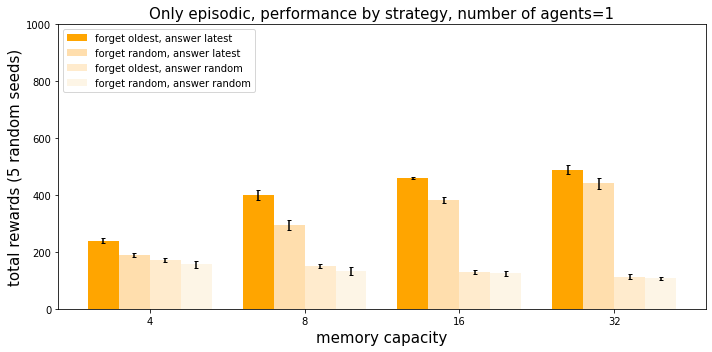

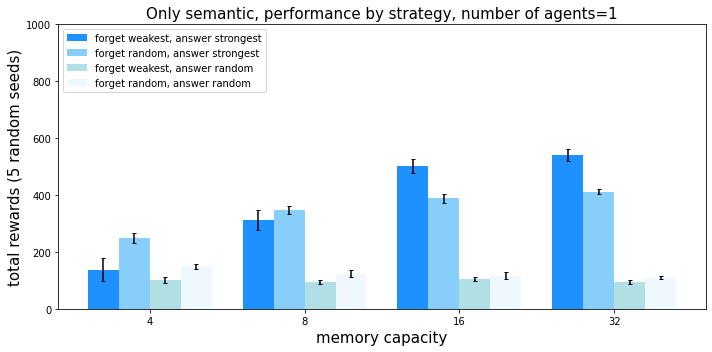

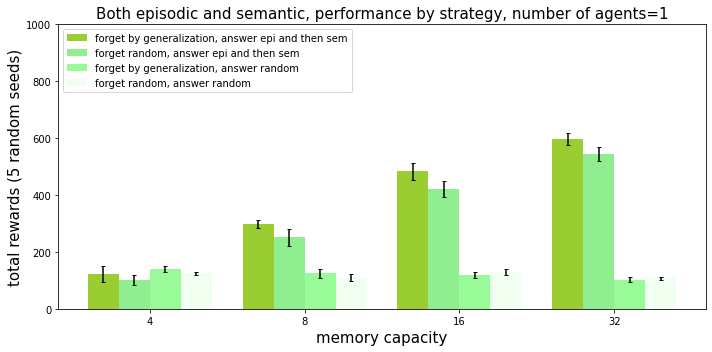

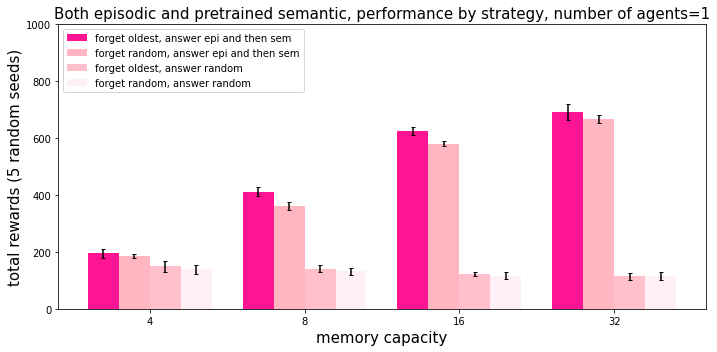

In [4]:
idx = np.asanyarray([i for i in range(len(caps))])
width = 0.2

for num_agents in num_agentss:
    for agent_type in agent_types:
        fig, ax = plt.subplots(figsize=(10, 5))

        if agent_type == "episodic":
            strategy_order = [
                "oldest_latest",
                "random_latest",
                "oldest_random",
                "random_random",
            ]

            legend_order = [
                "forget oldest, answer latest",
                "forget random, answer latest",
                "forget oldest, answer random",
                "forget random, answer random",
            ]

            color_order = ["orange", "navajowhite", "blanchedalmond", "oldlace"]

        elif agent_type == "semantic":
            strategy_order = [
                "weakest_strongest",
                "random_strongest",
                "weakest_random",
                "random_random",
            ]

            legend_order = [
                "forget weakest, answer strongest",
                "forget random, answer strongest",
                "forget weakest, answer random",
                "forget random, answer random",
            ]

            color_order = ["dodgerblue", "lightskyblue", "powderblue", "aliceblue"]

        elif agent_type == "episodic_semantic":
            strategy_order = [
                "generalize_episem",
                "random_episem",
                "generalize_random",
                "random_random",
            ]

            legend_order = [
                "forget by generalization, answer epi and then sem",
                "forget random, answer epi and then sem",
                "forget by generalization, answer random",
                "forget random, answer random",
            ]

            color_order = ["yellowgreen", "lightgreen", "palegreen", "honeydew"]

        elif agent_type == "episodic_semantic_pretrain":
            strategy_order = [
                "oldest_episem",
                "random_episem",
                "oldest_random",
                "random_random",
            ]

            legend_order = [
                "forget oldest, answer epi and then sem",
                "forget random, answer epi and then sem",
                "forget oldest, answer random",
                "forget random, answer random",
            ]

            color_order = ["deeppink", "lightpink", "pink", "lavenderblush"]

        else:
            raise ValueError

        for strategy_type, w, color in zip(
            strategy_order, [-1.5, -0.5, 0.5, 1.5], color_order
        ):
            means = [
                results_all[agent_type][capacity][strategy_type][num_agents]["mean"]
                for capacity in caps
            ]
            stds = [
                results_all[agent_type][capacity][strategy_type][num_agents]["std"]
                for capacity in caps
            ]

            print(strategy_type, means)
            ax.bar(
                x=idx + w * width,
                height=means,
                yerr=stds,
                width=width,
                color=color,
                capsize=2,
            )
            ax.set_xticks(idx)
            ax.set_xticklabels(caps)
            ax.legend(legend_order, fontsize=10, loc="upper left")
            ax.set_xlabel("memory capacity", fontsize=15)
            ax.set_ylabel(f"total rewards ({len(seeds)} random seeds)", fontsize=15)

            ax.set_ylim([0, env_params["max_step"]])

            fig.tight_layout()
            if agent_type == "episodic":
                title = f"Only episodic, performance by strategy, number of agents={num_agents}"
            elif agent_type == "semantic":
                title = f"Only semantic, performance by strategy, number of agents={num_agents}"
            elif agent_type == "episodic_semantic":
                title = f"Both episodic and semantic, performance by strategy, number of agents={num_agents}"
            elif agent_type == "episodic_semantic_pretrain":
                title = f"Both episodic and pretrained semantic, performance by strategy, number of agents={num_agents}"
            else:
                raise ValueError

            plt.title(title, fontsize=15)
            plt.savefig(f"./figures/{agent_type}-{num_agents}.pdf", bbox_inches="tight")